#Завантаження библіотек


In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
from scipy.stats import spearmanr
from scipy.stats import rankdata
import math
drive.mount('/content/drive')
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 150)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1.Завантаження даних з файлу

In [ ]:
path = "/content/drive/MyDrive/Dataset/lab5/lin0.7.txt"
columns = ['x','y']
delimiter='     ';
df = pd.read_csv(path, delimiter,  header=None, names=columns)
print(df.head())

<ipython-input-12-9c0dc8f8692a>:4: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  df = pd.read_csv(path, delimiter,  header=None, names=columns)
<ipython-input-12-9c0dc8f8692a>:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(path, delimiter,  header=None, names=columns)


         x        y
0  11.8725  27.9046
1  12.0495  24.4759
2   4.9589  29.7647
3  11.7207  31.8058
4   6.9742  24.6826


#Creating class for calculation quantiles

In [ ]:
# Коефіцієнти для формули
C0 = 2.515_517
C1 = 0.802_853
C2 = 0.010_328
D1 = 1.432_788
D2 = 0.189_265_9
D3 = 0.001_308

class Quantile:

    @classmethod
    def calculate_quantile(cls, p):
        if p > 0.5:
            t = np.sqrt(-2 * np.log(1 - p))
            quantile = (t - ((C0 + C1 * t + C2 * t ** 2) / (1 + D1 * t + D2 * t ** 2 + D3 * t ** 3)))
        else:
            t = np.sqrt(-2 * np.log(p))
            quantile = -(t - ((C0 + C1 * t + C2 * t ** 2) / (1 + D1 * t + D2 * t ** 2 + D3 * t ** 3)))

        return quantile

    @staticmethod
    def student_quantile(p, v):
        up = Quantile.calculate_quantile(p)
        tpv = up + (1 / v) * (1 / 4) * (up ** 3 + up) + (1 / v ** 2) * (1 / 96) * (
            5 * up ** 5 + 16 * up ** 3 + 3 * up) + (1 / v ** 3) * (1 / 384) * (
                  3 * up ** 7 + 19 * up ** 5 + 17 * up ** 3 - 15 * up) + (1 / v ** 4) * (1 / 92_160) * (
                  79 * up ** 9 + 779 * up ** 7 + 1_482 * up ** 5 - 1_920 * up ** 3 - 945 * up)
        return tpv

    @staticmethod
    def fisher_quantile(p ,v1, v2):
        up = Quantile.calculate_quantile(p)

        sigma = 1/v1 + 1/v2
        delta = 1/v1 - 1/v2

        z = (up * np.sqrt(sigma / 2) -
         (1 / 6) * delta * (up**2 + 2) +
         np.sqrt(sigma / 2) * (sigma / 24 * (up**2 + 3 * up) + (1 / 72) * (delta**2 / sigma) * (up**3 + 11 * up)) -
         (sigma * delta / 120) * (up**4 + 9 * up**2 + 8) +
         (delta**3 / (3240 * sigma)) * (3 * up**4 + 7 * up**2 - 16) +
         np.sqrt(sigma / 2) * (sigma**2 / 1920 * (up**5 + 20 * up**3 + 15 * up)) +
         (delta**4 / 2880) * (up**5 + 44 * up**3 + 183 * up) +
         (delta**5 / (155520 * sigma**2)) * (9 * up**5 + 284 * up**3 + 1513 * up)
        )

        return np.exp(2*z)

### Creating class for calculating a Quantitative Characteristics

In [ ]:
class QuantitativeCharacteristics:

    def __init__(self,sample):
        self.sample = sample
        self.characteristic_fields_map = ["Mean", "Median", "Std", "Skewness", "Kurtosis"]
        self.characteristic_table_dictionary = dict()
        self.mean = None
        self.std_deviation = None
        self.a = None
        self.e = None
        self.sa = None
        self.se = None

    def add_to_dictionary(self, column_name, column_data):
        self.characteristic_table_dictionary.update({column_name: column_data})

    def display(self):
        self.add_characteristics()
        return self.characteristic_table_dictionary

    def add_characteristics(self):
        estimation = self.calculate_estimation()
        self.add_to_dictionary("Characteristic", self.characteristic_fields_map)
        self.add_to_dictionary("Estimation", estimation.keys())
        self.add_to_dictionary("SEM", estimation.values())
        confidence_intervals = self.calculate_confidence_interval(estimation)
        self.add_to_dictionary("95% Confidence Interval", confidence_intervals)

    def calculate_confidence_interval(self, estimation: dict):
        confidence_interval = list(range(0, 5))
        median_conf_interval = self.calculate_median_confidence_interval(list(estimation.keys())[1])
        confidence_interval[1] = f"[{median_conf_interval[0]}; {median_conf_interval[1]}]"

        v = len(self.sample) - 1
        student_quantile = Quantile.student_quantile(0.95, v)
        print("student_quantile: " + str(student_quantile))
        i = 0
        for key in estimation.keys():
            if (estimation.get(key) == "───"):
                i = i + 1
                continue
            upper_bound = round(key - student_quantile * estimation.get(key), 4)
            lower_bound = round(key + student_quantile * estimation.get(key), 4)
            confidence_interval[i] = f"[{upper_bound}; {lower_bound}]"

            i = i + 1

        return confidence_interval

    def calculate_median_confidence_interval(self, median):
        num_samples = 1000

        bootstrap_samples = [np.random.choice(self.sample, size=len(self.sample), replace=True) for _ in
                             range(num_samples)]

        bootstrap_medians = np.median(bootstrap_samples, axis=1)

        std_error_median = np.std(bootstrap_medians, ddof=1)
        v = len(self.sample) - 1
        student_quantile = Quantile.student_quantile(1 - 0.05 / 2, v)
        lower_bound = round(median - student_quantile * std_error_median, 4)
        upper_bound = round(median + student_quantile * std_error_median, 4)

        return lower_bound, upper_bound

    def calculate_normal_interval(self):
        v = len(self.sample) - 1
        student_quantile = Quantile.student_quantile(1 - 0.05 / 2, v)
        lower_bound = round(self.mean - student_quantile * self.std_deviation, 4)
        upper_bound = round(self.mean + student_quantile * self.std_deviation, 4)
        return lower_bound, upper_bound

    def calculate_estimation(self):
        estimation_map = dict()
        self.mean = round(np.mean(self.sample), 4)
        median = round(np.median(self.sample), 4)
        self.std_deviation = round(np.std(self.sample, ddof=1), 4)
        self.a = round(stats.skew(self.sample), 4)
        self.e = round(stats.kurtosis(self.sample), 4)

        n_len = len(self.sample)
        mean_std = round(self.std_deviation / np.sqrt(n_len), 4)
        std_std_deviation = round(self.std_deviation / np.sqrt(2 * n_len), 4)
        self.sa = round(np.sqrt(6 * n_len * (n_len - 1) / ((n_len - 2) * (n_len + 1) * (n_len + 3))), 4)
        self.se = round(
            np.sqrt(24 * n_len * (n_len - 1) ** 2 / ((n_len - 3) * (n_len - 2) * (n_len + 3) * (n_len + 5))), 4)

        estimation_map[self.mean] = mean_std
        estimation_map[median] = "───"
        estimation_map[self.std_deviation] = std_std_deviation
        estimation_map[self.a] = self.sa
        estimation_map[self.e] = self.se

        return estimation_map

### Methods for calculating correlation

In [ ]:
def pearson_correlation(x, y):
    x_n = len(x)
    sum_xy = sum((x-np.mean(x))*(y-np.mean(y)))
    sum_x_squared = sum((x-np.mean(x))**2)
    sum_y_squared = sum((y-np.mean(y))**2)
    print(f"log [DEBUG] sum_xy: {sum_xy}")
    print(f"log [DEBUG] sum_x_squared: {sum_x_squared}")
    print(f"log [DEBUG] sum_y_squared: {sum_y_squared}")
    corr = sum_xy / np.sqrt(sum_x_squared * sum_y_squared)

    statistic = ((corr*np.sqrt(x_n-2))/np.sqrt(1-corr**2))

    student_quantile = Quantile.student_quantile(1-0.05/2, x_n)
    if np.abs(statistic) > student_quantile:
      significant = 'significant'
      interconnection = 'exist'
    else:
      significant = 'insignificant'
      interconnection = 'non-exist'

    return corr, statistic, student_quantile, significant, interconnection

def count_concordant_discordant(x, y):
    concordant = 0
    discordant = 0
    n = len(x)
    for i in range(n):
        for j in range(i+1, n):
            if (x[i] < x[j] and y[i] < y[j]) or (x[i] > x[j] and y[i] > y[j]):
                concordant += 1
            elif (x[i] < x[j] and y[i] > y[j]) or (x[i] > x[j] and y[i] < y[j]):
                discordant += 1
    return concordant, discordant

def count_tied_ranks(x, y):
    x_ranks = rankdata(x)
    y_ranks = rankdata(y)
    return (x_ranks==y_ranks).sum()

def count_duplicates_in_list(my_list):
  duplicate_counts = {}
  for element in my_list:
    if element in duplicate_counts:
      duplicate_counts[element] += 1
    else:
      duplicate_counts[element] = 1
  # print(f'log [INFO] count_duplicates:{[x for x in duplicate_counts.values() if x>1]}')
  return [x for x in duplicate_counts.values() if x>1]

def calculate_c_for_andvase_kendall_corelation(x):
    return 0.5*sum([a*(a-1) for a in x])

def kendall_correlation(x, y):
    concordant, discordant = count_concordant_discordant(x, y)
    n = len(x)
    tied_ranks_quantity=count_tied_ranks(x,y)
    if tied_ranks_quantity == 0:
      corr = (concordant - discordant) / (0.5 * n * (n - 1))
    else:

      c =  calculate_c_for_andvase_kendall_corelation(count_duplicates_in_list(x))
      d =  calculate_c_for_andvase_kendall_corelation(count_duplicates_in_list(y))
      corr = ((concordant - discordant) /
      np.sqrt((0.5*n*(n - 1)-c)*(0.5*n*(n - 1)-d)))
      # print(f'log [INFO] c: {c}')
      # print(f'log [INFO] d: {d}')
      # print(f'log [INFO] (concordant - discordant): {(concordant - discordant)}')
      # print(f'log [INFO] with c: {0.5*n*(n - 1)-c}')
      # print(f'log [INFO] with d: {0.5*n*(n - 1)-d}')

    statistic = ((3*corr*np.sqrt(n*(n-1)))/np.sqrt(2*(2*n+5)))

    quantile = Quantile.calculate_quantile(1-0.05/2)
    if np.abs(statistic) > quantile:
      significant = 'significant'
      interconnection = 'exist'
    else:
      significant = 'insignificant'
      interconnection = 'non-exist'

    return corr, statistic, quantile, significant, interconnection

def calculate_class_quantity(sample):
  return math.ceil(1+1.44*np.log(len(sample)))

def transit_to_bounds(df):
  dictionary = dict()
  minimum = min(df['x'])
  maximum = max(df['x'])
  class_quantity = calculate_class_quantity(df['x'])
  # print(f'log [INFO] class_quantity: {class_quantity}')
  class_width = (maximum-minimum) / class_quantity

  # print(f'log [INFO] minimum: {minimum}')
  # print(f'log [INFO] maximum: {maximum}')
  # print(f'log [INFO] class_width: {class_width}')
  class_bounds=[minimum+(l)*class_width for l in range(0,class_quantity+1)]
  # print(f'log [INFO] class_bounds: {class_bounds}')
  class_median = [0.5*(class_bounds[i]+class_bounds[i+1])

  for i in range(len(class_bounds) - 1)]
  # print(f'log [INFO] class_median: {class_median}')
  dictionary = {median: [] for median in class_median}
  for i in range(len(class_median)):
    for j in range(len(df['x'])):
      if (df['x'][j]>class_bounds[i] and df['x'][j]<class_bounds[i+1]):
        dictionary[class_median[i]].append(df['y'][j])

  dictionary[list(dictionary.keys())[0]].append(df['y'][np.argmin(df['x'])])
  dictionary[list(dictionary.keys())[-1]].append(df['y'][np.argmax(df['x'])])
  # print(f'log [DEBUG] dictionary: {dictionary}')
  return dictionary

def calculate_correlation_ratio(df, pirson_corr):
  n = len(df['x'])
  data= transit_to_bounds(df)
  k = len(data)

  non_empty_data = {key: value for key, value in data.items() if value}

  bins = list(non_empty_data.keys())
  data_points = [val for value_list in non_empty_data.values()
  for val in value_list]

  m=np.mean(data_points)
  std = np.std(data_points, ddof=1)**2

  corr = (sum([(np.mean(f)-m)**2*len(f) for f in non_empty_data.values()])/
   (len(data_points)-1)/std)**0.5

  statistic = ((corr**2/(k-1))/((1-corr**2)/(n-k)))
  fisher_quantile = Quantile.fisher_quantile(1-0.05,k-1,n-k)
  if np.abs(statistic) > fisher_quantile:
    significant = 'significant'
    interconnection = 'exist'
  else:
    significant = 'insignificant'
    interconnection = 'non-exist'

  return corr, statistic, fisher_quantile, significant, interconnection

def check_dependence(corr,pirson_corr,k,n):
  lineral_statistic = (((corr**2-pirson_corr)/(k-2))/((1-corr)/(n-k)))
  print(f"log [INFO] lineral_statistic: {lineral_statistic}")
  fisher_quantile = Quantile.fisher_quantile(1-0.05,k-2,n-k)
  print(f"log [INFO] fisher_quantile: {fisher_quantile}")
  if lineral_statistic > fisher_quantile:
    dependence_type = 'non-linear'
  else:
    dependence_type = 'linear'

  return dependence_type;


### Methods for calculating correlation

In [ ]:
def calculate_correlation_ci(df, estimation):


  z_r = 0.5 * np.log((1 + estimation) / (1 - estimation))

  quantile = Quantile.calculate_quantile(0.95)

  se_zr = 1 / np.sqrt(len(df['x']) - 3)
  z_r_lower = z_r - quantile * se_zr
  z_r_upper = z_r + quantile * se_zr
  r_lower = (np.exp(2 * z_r_lower) - 1) / (np.exp(2 * z_r_lower) + 1)
  r_upper = (np.exp(2 * z_r_upper) - 1) / (np.exp(2 * z_r_upper) + 1)
  confidence_interval = f"[{r_lower:.4f}; {r_upper:.4f}]"

  return confidence_interval

## 2.	Побудова кореляційного поля.

<Axes: xlabel='x', ylabel='y'>

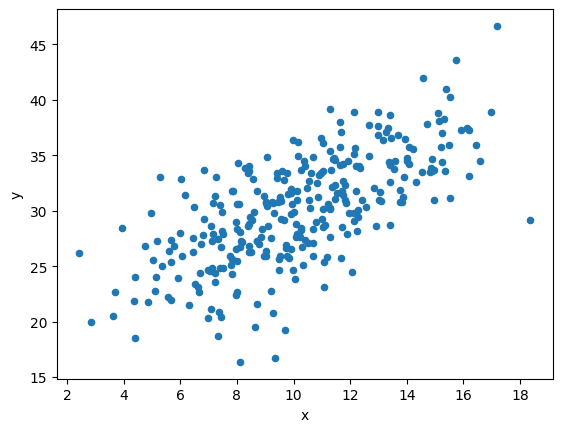

In [ ]:
df.plot.scatter(x='x',y='y')

#3.	Оцінювання статистичних характеристик для кожної ознаки.

In [ ]:
q_c1 = QuantitativeCharacteristics(df['x'])
print(q_c1.characteristic_table_dictionary)
q_c2 = QuantitativeCharacteristics(df['y'])
res1= pd.DataFrame(q_c1.display())
print(res1)
print('----------')
res2=  pd.DataFrame(q_c2.display())
print(res2)

{}
student_quantile: 1.650323668219721
  Characteristic  Estimation     SEM 95% Confidence Interval
0           Mean     10.1745  0.1742         [9.887; 10.462]
1         Median     10.0922     ───       [9.7125; 10.4719]
2            Std      3.0176  0.1232        [2.8143; 3.2209]
3       Skewness      0.1021  0.1407       [-0.1301; 0.3343]
4       Kurtosis     -0.3974  0.2805       [-0.8603; 0.0655]
----------
student_quantile: 1.650323668219721
  Characteristic  Estimation     SEM 95% Confidence Interval
0           Mean     30.0862  0.2849       [29.616; 30.5564]
1         Median     30.3859     ───      [29.5906; 31.1812]
2            Std      4.9351  0.2015        [4.6026; 5.2676]
3       Skewness     -0.0397  0.1407       [-0.2719; 0.1925]
4       Kurtosis      0.0331  0.2805        [-0.4298; 0.496]


#4.	Перевірку наявності стохастичного зв’язку між окремими ознаками.

In [ ]:
table ={}

pirson = pearson_correlation(df['x'], df['y'])
spearman = pearson_correlation(df['x'].rank(), df['y'].rank())
kendall = kendall_correlation(df['x'], df['y'])
ratio = calculate_correlation_ratio(df,pirson[0])

table['Coefficient'] =['Pirson Corelation','Spearman Corelation',
                       'Kendall Corelation','Correlation Ratio']

table['Value'] =[pirson[0],spearman[0],kendall[0],ratio[0]]

table['Confidence Interval'] =[calculate_correlation_ci(df, pirson[0]),
                               '───','───','───']

table['Statistic'] =[pirson[1],spearman[1],kendall[1],ratio[1]]

table['Quantile'] =[pirson[2],spearman[2],kendall[2],ratio[2]]

table['Is Significant'] =[pirson[3],spearman[3],kendall[3],ratio[3]]

table['Presence of a Relationship'] =[pirson[4],spearman[4],kendall[4],ratio[4]]

print(pd.DataFrame(table))

log [DEBUG] sum_xy: 3029.8128561912035
log [DEBUG] sum_x_squared: 2722.6719563059646
log [DEBUG] sum_y_squared: 7282.104893240802
log [DEBUG] sum_xy: 1550008.5
log [DEBUG] sum_x_squared: 2249974.5
log [DEBUG] sum_y_squared: 2249974.5
           Coefficient     Value Confidence Interval  Statistic  Quantile Is Significant Presence of a Relationship
0    Pirson Corelation  0.680440    [0.6258; 0.7284]  16.029131  1.968336    significant                      exist
1  Spearman Corelation  0.688900                 ───  16.406386  1.968336    significant                      exist
2   Kendall Corelation  0.494192                 ───  12.764981  1.960392    significant                      exist
3    Correlation Ratio  0.677164                 ───  27.288916  1.903591    significant                      exist


In [ ]:
new_df=transit_to_bounds(df)
ddf={}
last_table={}
ddf['x']=[x for x in new_df.keys()]
ddf['y']=[np.mean(items) for items in new_df.values()]# Average the elements in each nested list
ddf = pd.DataFrame(ddf)
#print(ddf)

k = calculate_class_quantity(df['x'])
n=len(df['x'])
pirson = pearson_correlation(ddf['x'], ddf['y'])
addiction_type=check_dependence(ratio[0],pirson[0],k,n)
equal = 'equal' if pirson[3]=='significant' else 'unequal'

last_table['Estimation of the Pearson coefficient'] =[pirson[0]]
last_table['Value'] =[ratio[0]]
last_table['Statistic'] =[pirson[1]]
last_table['Quantile'] =[pirson[2]]
last_table['Conclusion'] =[equal]
last_table['Conclusion on the type of addiction'] =[addiction_type]

print(pd.DataFrame(last_table))

log [DEBUG] sum_xy: 219.2202417496341
log [DEBUG] sum_x_squared: 209.10378733200008
log [DEBUG] sum_y_squared: 231.42478669944856
log [INFO] lineral_statistic: -60.4087015126018
log [INFO] fisher_quantile: 1.9596271138908825
   Estimation of the Pearson coefficient     Value  Statistic  Quantile Conclusion Conclusion on the type of addiction
0                                0.99654  0.677164  33.913078  2.228722      equal                              linear


#Висновок для завдання номер 9
## Перевірте, чи є залежність між цими величинами.
### Так залежнысть між цими величинами присутня
## На скільки сильна?
### від 0.7 до 0.9 зв'язок сильний
## Який тип цієї залежності?
### Тип залежності лінійний